In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import time
import random
from sklearn.decomposition import PCA
from PIL import Image
from collections import Counter
from sklearn.model_selection import train_test_split

temps_debut = time.time()

# Chemins des fichiers CSV et images
chemin_x_train = r'C:\Users\pc\Documents\Data Scientist\Rakuten_true\Data_rakuten\X_train_update.csv'
chemin_y_train = r'C:\Users\pc\Documents\Data Scientist\Rakuten_true\Data_rakuten\Y_train_CVw08PX.csv'
chemin_images = r'C:\Users\pc\Documents\Data Scientist\Rakuten_true\Data_rakuten\images\image_train'

x_train = pd.read_csv(chemin_x_train, index_col='Unnamed: 0')
y_train = pd.read_csv(chemin_y_train, index_col='Unnamed: 0')

# Equilibrer l'échantillon selon les classes de prdtypecode
df_j1 = pd.merge(x_train, y_train, left_index=True, right_index=True)
tableau_croise = pd.crosstab(index=df_j1['prdtypecode'], columns='Fréquence')
print(tableau_croise)

nombre_echantillons_par_classe = df_j1['prdtypecode'].value_counts().min()

echantillon_equilibre = []
for prdtypecode in df_j1['prdtypecode'].unique():
    indices_prdtypecode = df_j1[df_j1['prdtypecode'] == prdtypecode].index.tolist()
    indices_selectionnes = random.sample(indices_prdtypecode, nombre_echantillons_par_classe)
    echantillon_equilibre.extend(df_j1.loc[indices_selectionnes, ['productid', 'imageid']].values.tolist())

images_select = []

for productid, imageid in echantillon_equilibre:
    nom_fichier = f"image_{imageid}_product_{productid}.jpg"
    chemin_image = os.path.join(chemin_images, nom_fichier)
    if os.path.isfile(chemin_image):
        images_select.append([productid, imageid, prdtypecode])

df_images_info = pd.DataFrame(images_select, columns=['productid', 'imageid', 'prdtypecode'])

print(df_images_info.head())  # Afficher les premières lignes du dataframe d'informations sur les images
print("Nombre total d'images sélectionnées :", len(df_images_info))
print(images_select[:10])


col_0        Fréquence
prdtypecode           
10                3116
40                2508
50                1681
60                 832
1140              2671
1160              3953
1180               764
1280              4870
1281              2070
1300              5045
1301               807
1302              2491
1320              3241
1560              5073
1920              4303
1940               803
2060              4993
2220               824
2280              4760
2403              4774
2462              1421
2522              4989
2582              2589
2583             10209
2585              2496
2705              2761
2905               872
    productid     imageid  prdtypecode
0   110661981   867519844         1301
1     1010057  1274746013         1301
2  2014805058  1268253771         1301
3   123316324   878095781         1301
4  1859671885  1106023314         1301
Nombre total d'images sélectionnées : 20628
[[110661981, 867519844, 1301], [1010057, 1274746013, 13

In [8]:
# Enlever les images qui ne sont pas aux bonnes dimensions en entrée
dimensions_images = []
for image_name in images_select:
    nom_fichier = f"image_{imageid}_product_{productid}.jpg"
    chemin_im = os.path.join(chemin_images, nom_fichier)    
    image = cv2.imread(chemin_im)
    hauteur, largeur, _ = image.shape
    dimensions_images.append((hauteur, largeur))

largeurs, hauteurs = zip(*dimensions_images)
frequence_largeurs = Counter(largeurs)
frequence_hauteurs = Counter(hauteurs)
print("Fréquences des largeurs :\n", frequence_largeurs)
print("\nFréquences des hauteurs :\n", frequence_hauteurs)


Fréquences des largeurs :
 Counter({500: 20628})

Fréquences des hauteurs :
 Counter({500: 20628})


In [9]:
temps_debut = time.time()

# extraire les données des images 
largeur_im=100
hauteur_im=100
donnees=[]

for productid, imageid, prdtypecode in images_select:
    nom_fichier = f"image_{imageid}_product_{productid}.jpg"
    chemin_image = os.path.join(chemin_images, nom_fichier)
       
    # Charger l'image en niveaux de gris
    image = cv2.imread(chemin_image)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    kernelx = cv2.getDerivKernels(1, 0, 3)
    kernely = cv2.getDerivKernels(0, 1, 3)
    prewitt_x = cv2.filter2D(blurred, -1, kernelx[0] * kernelx[1].T)
    prewitt_y = cv2.filter2D(blurred, -1, kernely[0] * kernely[1].T)
    prewitt_cross = cv2.addWeighted(prewitt_x, 0.5, prewitt_y, 0.5, 0)
    
    contours, _ = cv2.findContours(prewitt_cross, cv2.RETR_TREE, cv2.CHAIN_APPROX_TC89_L1)

    bounding_boxes = []
    for contour in contours:
        # Trouver les coordonnées de la boîte englobante du contour actuel
        x, y, w, h = cv2.boundingRect(contour)
        # Ajouter les coordonnées de la boîte englobante à la liste
        bounding_boxes.append((x, y, w, h))

    if bounding_boxes:
        bounding_boxes_array = np.array(bounding_boxes)
        min_x, min_y, min_w, min_h = np.min(bounding_boxes_array, axis=0)
        max_x, max_y, max_w, max_h = np.max(bounding_boxes_array, axis=0)
    else:
        # Gérer le cas où bounding_boxes est vide
        min_x, min_y, min_w, min_h = 0, 0, 0, 0
        max_x, max_y, max_w, max_h = 500, 500, 500, 500

    # Extraire la région de l'image couverte par la boîte englobante
    cropped_image = image[min_y:min_y+max_h, min_x:min_x+max_w]
    
    # Redimensionner l'image sans conserver le ratio d'aspect
    image_redim = cv2.resize(cropped_image, (largeur_im, hauteur_im))
    image_redim_rgb = cv2.cvtColor(image_redim, cv2.COLOR_BGR2RGB)
    
    canal_r, canal_g, canal_b = cv2.split(image_redim_rgb)
    rouge=canal_r.flatten().tolist()
    vert=canal_g.flatten().tolist()
    bleu=canal_b.flatten().tolist()

    # Vérifier si le nombre de pixels correspond 
    nb_pixels = len(rouge) + len(vert) + len(bleu)
    if nb_pixels != 3 * largeur_im * hauteur_im:
        print(f"L'image {nom_fichier} ne contient pas le bon nombre de pixels.")
    else:
        # Ajouter les données à la liste
        donnees.append({
            'imageid': imageid,
            'productid': productid,
            'featr': rouge,
            'featv': vert,
            'featb': bleu
        })



In [4]:
colonnes = ['imageid', 'productid', 'featr', 'featv', 'featb']
df_images = pd.DataFrame(donnees, columns=colonnes)
df_images['productid'] = df_images['productid'].astype(str)
df_images['imageid'] = df_images['imageid'].astype(str)

X_train['productid'] = X_train['productid'].astype(str)
X_train['imageid'] = X_train['imageid'].astype(str)

df_jointure1 = pd.merge(X_train, y_train, left_index=True, right_index=True)
df_jointure2 = pd.merge(df_images, df_jointure1, on=['productid', 'imageid'])

nb_features_total = largeur_im * hauteur_im
featr_df = df_jointure2['featr'].apply(lambda x: pd.Series(x))
featv_df = df_jointure2['featv'].apply(lambda x: pd.Series(x))
featb_df = df_jointure2['featb'].apply(lambda x: pd.Series(x))

featr_df.rename(columns={i: f'r{i}' for i in range(nb_features_total)}, inplace=True)
featv_df.rename(columns={i: f'g{i}' for i in range(nb_features_total)}, inplace=True)
featb_df.rename(columns={i: f'b{i}' for i in range(nb_features_total)}, inplace=True)

df_jointure2 = pd.concat([df_jointure2, featr_df, featv_df, featb_df], axis=1)
df_jointure2.drop(columns=['featr','featv', 'featb'], inplace=True)

print(df_jointure2)
# Arrêter le compteur de temps
temps_fin = time.time()
temps_execution = temps_fin - temps_debut
print("Temps d'exécution:", temps_execution, "secondes")

          imageid   productid  \
0      1265189559  3928016388   
1      1075332620  1342442713   
2      1276010290  4010222606   
3      1276075493  4010225777   
4      1299697453  4143428925   
...           ...         ...   
13603  1100079820  1711735890   
13604  1100077415  1711735231   
13605  1100085891  1711735257   
13606  1100064529  1711736492   
13607  1100076528  1711735998   

                                             designation  \
0      Sarbacane 36 " ( 91 Cm ) Calibre .40 Blow Guns...   
1               Beachball Huggies Little Swimmers Disney   
2      Gâteau Cartoon Crème Parfumée Lente Hausse Ant...   
3      Poule Surprise Oeufs Arc-En-Starry Couché Crea...   
4                        Bmw 6 Gt Licence Officielle 12v   
...                                                  ...   
13603     Anomaly: Warzone Earth - Jeu En Téléchargement   
13604  Borderlands: The Pre-Sequel Season Pass (Mac -...   
13605            Motorcycle Club - Jeu En Téléchargement   
136

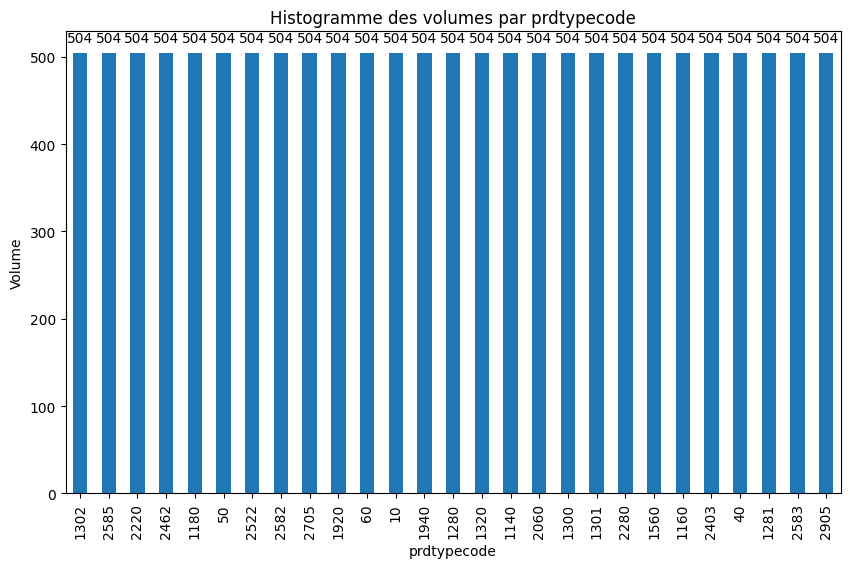

In [10]:
import matplotlib.pyplot as plt

volumes = df_jointure2['prdtypecode'].value_counts()

plt.figure(figsize=(10, 6))
ax = volumes.plot(kind='bar')
plt.title('Histogramme des volumes par prdtypecode')
plt.xlabel('prdtypecode')
plt.ylabel('Volume')
plt.xticks(rotation=90)  

for i, v in enumerate(volumes):
    ax.text(i, v + 10, str(v), ha='center', va='bottom')

plt.show()

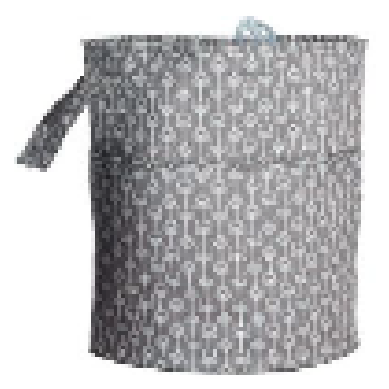

In [40]:
import cv2
import matplotlib.pyplot as plt

row_index = 2500
row = df_jointure2.iloc[row_index]

r_values = row[['r' + str(i) for i in range(nb_features_total)]].values
g_values = row[['g' + str(i) for i in range(nb_features_total)]].values
b_values = row[['b' + str(i) for i in range(nb_features_total)]].values

r_values = r_values.astype(np.uint8)
g_values = g_values.astype(np.uint8)
b_values = b_values.astype(np.uint8)

image = cv2.merge([r_values.reshape(largeur_im, hauteur_im), 
                   g_values.reshape(largeur_im, hauteur_im), 
                   b_values.reshape(largeur_im, hauteur_im)])

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')  
plt.show()


In [41]:
dfn=df_jointure2
pixel_columns = dfn.columns[dfn.columns.str.startswith('r') | dfn.columns.str.startswith('g') | dfn.columns.str.startswith('b')]

# Appliquer la transformation /255 à toutes les colonnes de pixels
dfn[pixel_columns] = dfn[pixel_columns].apply(lambda x: x / 255)

print(dfn)

          imageid   productid  \
0      1204323393   414489692   
1      1294596751  4123550963   
2       895477011     1174202   
3      1298768118  4140073156   
4      1061629256  1104492008   
...           ...         ...   
20623  1023179244   533384100   
20624  1261407478  3898721389   
20625   947549202   209925253   
20626  1261369347  3898715946   
20627   893312834   141191327   

                                             designation  \
0      Prize W: 700 Pensamientos Para Desarrollar Una...   
1        London Review Of English And Foreign Literature   
2              Constantin Guys 1802-1892 - Fleurs Du Mal   
3                     Weaving With The Rigid Heddle Loom   
4                                     Je Suis Une Île...   
...                                                  ...   
20623     Bille Blanche Pro Cup 527 Mm (Blister)-Aramith   
20624  Nouveau-né bébé Cartoon bébé nouveau-né Filles...   
20625  Melissa & Doug - 11637 - Loisir Créatif - Rain...   
206

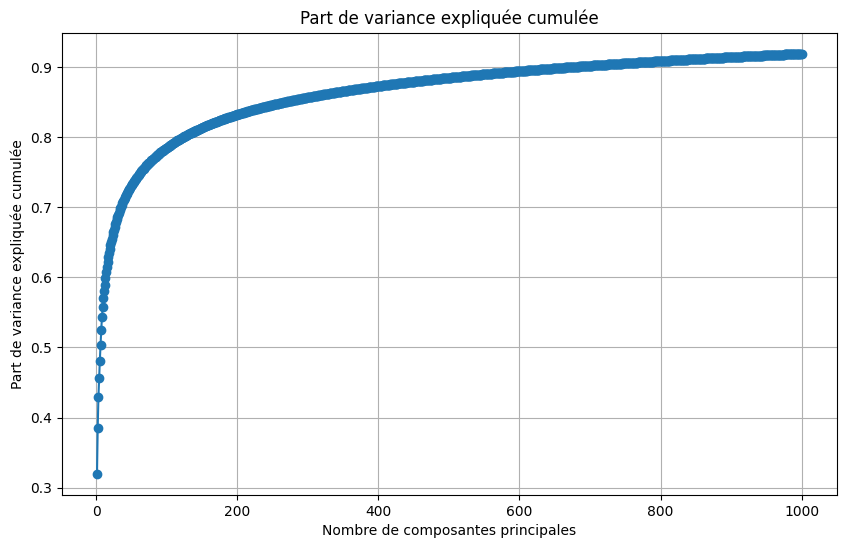

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

df_target = dfn[['prdtypecode']].copy()
df_features = dfn.drop(columns=['imageid', 'productid', 'designation', 'description', 'prdtypecode'])
df_features.columns = df_features.columns.astype(str)
nbp=1000
scaler = StandardScaler()
df_features_scaled = scaler.fit_transform(df_features)

# Appliquer la PCA
pca = PCA(n_components=nbp)
pca.fit(df_features_scaled)
explained_variance_ratio = pca.explained_variance_ratio_

cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)

# Tracer le graphe de la part de variance expliquée cumulée
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance_ratio) + 1), cumulative_explained_variance_ratio, marker='o', linestyle='-')
plt.title('Part de variance expliquée cumulée')
plt.xlabel('Nombre de composantes principales')
plt.ylabel('Part de variance expliquée cumulée')
plt.grid(True)
plt.show()


In [44]:
rang_90 = np.argmax(cumulative_explained_variance_ratio >= 0.9) + 1
print("Rang où la part de variance expliquée dépasse 90% :", rang_90)

Rang où la part de variance expliquée dépasse 90% : 669


In [56]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, f1_score

nb_comprin = 669  
df_target = dfn[['prdtypecode']].copy()
df_features_pca = pca.transform(df_features_scaled)[:, :nb_comprin]
columns_pca = [f'PC{i}' for i in range(1, nb_comprin+1)]
df_features_pca = pd.DataFrame(data=df_features_pca, columns=columns_pca)

unique_classes = df_target['prdtypecode'].unique()
expected_classes = np.arange(27)  
class_mapping = {real_class: expected_class for real_class, expected_class in zip(unique_classes, expected_classes)}
df_target['prdtypecode'] = df_target['prdtypecode'].map(class_mapping)

X_train, X_test, y_train, y_test = train_test_split(df_features_pca, df_target, test_size=0.2, random_state=23,stratify=df_target['prdtypecode'])
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
print(class_mapping)

(16502, 669) (16502, 1) (4126, 669) (4126, 1)
{10: 0, 2280: 1, 50: 2, 1280: 3, 2705: 4, 2522: 5, 2582: 6, 1560: 7, 1281: 8, 1920: 9, 2403: 10, 1140: 11, 2583: 12, 1180: 13, 1300: 14, 2462: 15, 1160: 16, 2060: 17, 40: 18, 60: 19, 1320: 20, 1302: 21, 2220: 22, 2905: 23, 2585: 24, 1940: 25, 1301: 26}


In [60]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, f1_score
import warnings

warnings.filterwarnings("ignore")

rf_classifier = RandomForestClassifier()
xgb_classifier = XGBClassifier()
lr_classifier = LogisticRegression(max_iter=200)
svm_classifier = SVC()

temps_0=time.time()
rf_classifier.fit(X_train, y_train)
rf_predictions = rf_classifier.predict(X_test)
rf_f1_score = f1_score(y_test, rf_predictions, average='weighted')

temps_1=time.time()
xgb_classifier.fit(X_train, y_train)
xgb_predictions = xgb_classifier.predict(X_test)
xgb_f1_score = f1_score(y_test, xgb_predictions, average='weighted')

temps_2=time.time()
lr_classifier.fit(X_train, y_train)
lr_predictions = lr_classifier.predict(X_test)
lr_f1_score = f1_score(y_test, lr_predictions, average='weighted')

temps_3=time.time()
svm_classifier.fit(X_train, y_train)
svm_predictions = svm_classifier.predict(X_test)
svm_f1_score = f1_score(y_test, svm_predictions, average='weighted')

temps_4=time.time()

print("Random Forest F1 Score:", rf_f1_score, temps_1-temps_0)
print("XGBoost F1 Score:", xgb_f1_score, temps_2-temps_1 )
print("Logistic Regression F1 Score:", lr_f1_score, temps_3-temps_2)
print("SVM F1 Score:", svm_f1_score, temps_4-temps_3)

Random Forest F1 Score: 0.20193127958374757 127.99700665473938
XGBoost F1 Score: 0.2504101010715518 605.9416811466217
Logistic Regression F1 Score: 0.19258829935284433 23.431384801864624
SVM F1 Score: 0.2711731348461553 205.22857785224915


In [59]:
rf_accuracy = accuracy_score(y_test, rf_predictions)
xgb_accuracy = accuracy_score(y_test, xgb_predictions)
lr_accuracy = accuracy_score(y_test, lr_predictions)
svm_accuracy = accuracy_score(y_test, svm_predictions)

print("Random Forest Precision:", rf_accuracy)
print("XGBoost Precision:", xgb_accuracy)
print("Logistic Regression Precision:", lr_accuracy)
print("SVM Precision:", svm_accuracy)

Random Forest Precision: 0.20988851187590887
XGBoost Precision: 0.2578768783325254
Logistic Regression Precision: 0.1975278720310228
SVM Precision: 0.28162869607367913


In [61]:
import warnings
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

warnings.filterwarnings("ignore")
temps_debut = time.time()

# Définition des modèles
rf_classifier = RandomForestClassifier()
xgb_classifier = XGBClassifier()
lr_classifier = LogisticRegression(max_iter=200)
svm_classifier = SVC()

# Définition de la grille de recherche pour SVC
svm_param_grid = {
    'C': [0.001, 0.01, 0.1, 1.0, 10.0],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

# Création des objets GridSearchCV
svm_grid_search = GridSearchCV(svm_classifier, svm_param_grid, cv=3, scoring='f1_weighted',verbose=2, n_jobs=-1)
svm_grid_search.fit(X_train, y_train)

# Obtention des meilleures performances et paramètres pour chaque modèle

svm_best_params = svm_grid_search.best_params_
svm_best_score = svm_grid_search.best_score_


print("Meilleurs paramètres et score pour SVC :")
print("Paramètres :", svm_best_params)
print("Score F1 pondéré :", svm_best_score)
print()

Fitting 3 folds for each of 40 candidates, totalling 120 fits
Meilleurs paramètres et score pour SVC :
Paramètres : {'C': 10.0, 'gamma': 'scale', 'kernel': 'rbf'}
Score F1 pondéré : 0.28831251560069376



In [65]:
import warnings
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

warnings.filterwarnings("ignore")
temps_debut = time.time()

xgb_param_grid= {
    'max_depth': [5],
    'learning_rate': [0.1],
    'n_estimators': [200],
    'gamma': [0.1],
    'subsample': [0.9],
    'colsample_bytree': [0.9],
    'reg_alpha': [0.1],
    'reg_lambda': [0, 0.1]
}

# Création des objets GridSearchCV
xgb_grid_search = GridSearchCV(xgb_classifier, xgb_param_grid, cv=3, scoring='f1_weighted',verbose=2, n_jobs=-1)
xgb_grid_search.fit(X_train, y_train)

xgb_best_params = xgb_grid_search.best_params_
xgb_best_score = xgb_grid_search.best_score_

temps_fin = time.time()
print("Meilleurs paramètres et score pour XGBClassifier :")
print("Paramètres :", xgb_best_params)
print("Score F1 pondéré :", xgb_best_score, temps_fin-temps_debut)
print()

Fitting 3 folds for each of 2 candidates, totalling 6 fits
Meilleurs paramètres et score pour XGBClassifier :
Paramètres : {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'reg_alpha': 0.1, 'reg_lambda': 0, 'subsample': 0.9}
Score F1 pondéré : 0.23936494997753552 3063.659820318222

